In [2]:
# ============================================
# Environment Setup
# ============================================

# Core scientific + ML libraries
!pip install numpy pandas scikit-learn xgboost imbalanced-learn -q

# Visualization
!pip install matplotlib seaborn shap -q

# Interface for demo
!pip install gradio -q

# Confirm installation
import numpy as np, pandas as pd, sklearn, xgboost, imblearn, shap, gradio
import matplotlib, seaborn

print("✅ All packages installed successfully!\n")
print("Library Versions:")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"XGBoost: {xgboost.__version__}")
print(f"Imbalanced-learn: {imblearn.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn: {seaborn.__version__}")
print(f"SHAP: {shap.__version__}")


✅ All packages installed successfully!

Library Versions:
Numpy: 2.0.2
Pandas: 2.2.2
Scikit-learn: 1.6.1
XGBoost: 3.1.2
Imbalanced-learn: 0.14.0
Matplotlib: 3.10.0
Seaborn: 0.13.2
SHAP: 0.50.0


In [3]:
# ============================================
# Import Libraries
# ============================================

# Data & computation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px


# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Data balancing
from imblearn.over_sampling import SMOTE

# Explainability
import shap

# Web app
import gradio as gr

# Utility
import warnings
warnings.filterwarnings("ignore")

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Libraries imported and environment configured successfully!")


✅ Libraries imported and environment configured successfully!


📥 Downloading Kepler dataset...
✅ Dataset loaded successfully!

Shape of dataset: (8054, 153)

First 5 rows:


,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score
0,10811496,K00753.01,NaN,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,0,0,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.0
1,10848459,K00754.01,NaN,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,0,0,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.0
2,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,0,0,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.0
3,10872983,K00756.01,Kepler-228 d,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,114.81,112.85,-36.70,0.67324,0.33286,-0.38858,LS+MCMC,1.0
4,10872983,K00756.02,Kepler-228 c,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,427.65,420.33,-136.70,0.37377,0.74768,-0.26357,LS+MCMC,1.0



📊 Column names:
['kepid', 'kepoi_name', 'kepler_name', 'ra', 'ra_err', 'ra_str', 'dec', 'dec_err', 'dec_str', 'koi_gmag', 'koi_gmag_err', 'koi_rmag', 'koi_rmag_err', 'koi_imag', 'koi_imag_err', 'koi_zmag', 'koi_zmag_err', 'koi_jmag', 'koi_jmag_err', 'koi_hmag', 'koi_hmag_err', 'koi_kmag', 'koi_kmag_err', 'koi_kepmag', 'koi_kepmag_err', 'koi_delivname', 'koi_vet_stat', 'koi_quarters', 'koi_disposition', 'koi_pdisposition', 'koi_count', 'koi_num_transits', 'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_bin_oedp_sig', 'koi_limbdark_mod', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_trans_mod', 'koi_model_snr', 'koi_model_dof', 'koi_model_chisq', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_eccen', 'koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_sma', 'koi_sma_err1', 'koi_sma_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_dura

,0
koi_gmag_err,8054
koi_imag_err,8054
koi_zmag_err,8054
koi_rmag_err,8054
koi_kepmag_err,8054
koi_longp_err2,8054
koi_sage_err2,8054
koi_sage_err1,8054
koi_sage,8054
koi_sma_err1,8054



🪐 Class distribution (koi_disposition):
koi_disposition
FALSE POSITIVE    3965
CONFIRMED         2729
CANDIDATE         1360
Name: count, dtype: int64


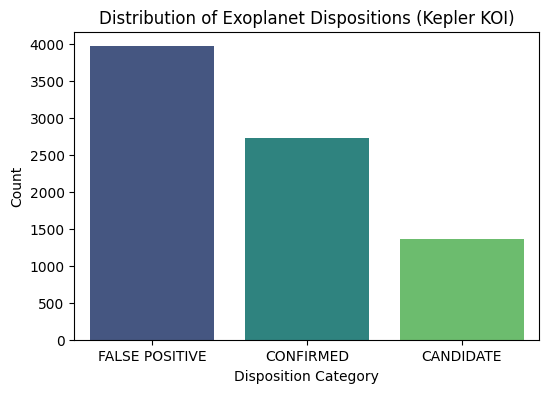


📈 Numeric Summary:


,count,mean,std,min,25%,50%,75%,max
kepid,8054.0,7.694620e+06,2.654587e+06,757450.000000,5.559946e+06,7.908367e+06,9.881662e+06,1.293514e+07
ra,8054.0,2.920947e+02,4.786925e+00,279.856080,2.887114e+02,2.923115e+02,2.959091e+02,3.017208e+02
ra_err,8054.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
dec,8054.0,4.381637e+01,3.603021e+00,36.577381,4.077990e+01,4.368107e+01,4.672281e+01,5.233601e+01
dec_err,8054.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
koi_gmag,8021.0,1.488161e+01,1.485279e+00,7.225000,1.397800e+01,1.512200e+01,1.596400e+01,2.041000e+01
koi_gmag_err,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
koi_rmag,8046.0,1.426981e+01,1.370288e+00,7.101000,1.344725e+01,1.452100e+01,1.529375e+01,1.996000e+01
koi_rmag_err,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
koi_imag,7922.0,1.412394e+01,1.275856e+00,7.627000,1.335300e+01,1.436150e+01,1.507900e+01,1.990000e+01


In [4]:
# ============================================
# Load and Explore Kepler Dataset
# ============================================

# Kepler Objects of Interest (KOI) dataset from NASA Exoplanet Archive
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+q1_q17_dr25_koi&format=csv"

print("📥 Downloading Kepler dataset...")
df = pd.read_csv(url)
print("✅ Dataset loaded successfully!\n")

# Basic info
print(f"Shape of dataset: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Show column names
print("\n📊 Column names:")
print(df.columns.tolist())

# Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
print("\n🔍 Missing Values (Top 15):")
display(missing.head(15))

# Explore disposition (target variable)
if "koi_disposition" in df.columns:
    print("\n🪐 Class distribution (koi_disposition):")
    print(df["koi_disposition"].value_counts())

    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x="koi_disposition", palette="viridis")
    plt.title("Distribution of Exoplanet Dispositions (Kepler KOI)")
    plt.xlabel("Disposition Category")
    plt.ylabel("Count")
    plt.show()
else:
    print("⚠️ 'koi_disposition' column not found — check dataset schema.")

# Quick numeric summary
print("\n📈 Numeric Summary:")
display(df.describe().T.head(10))


🔧 Cleaning and preparing data...
✅ Selected 15 useful features.
✅ Cleaned dataset shape: (7012, 18)
📊 Class distribution after cleaning:
label
2    3056
0    2691
1    1265
Name: count, dtype: int64


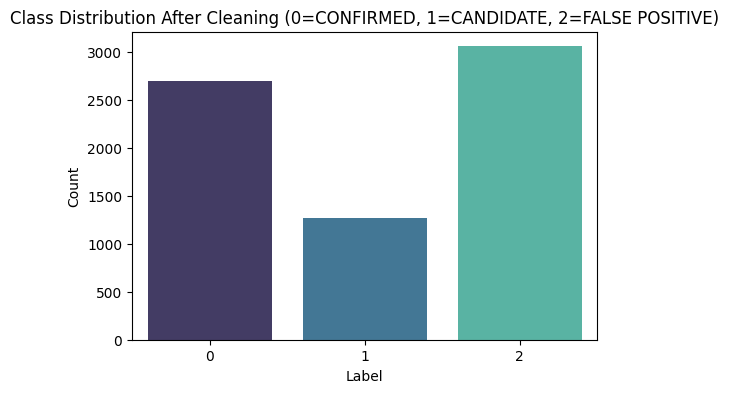


📈 Feature Summary:


,count,mean,std,min,25%,50%,75%,max
koi_period,7012.0,22.82,44.00,0.26,2.34,7.05,20.18,295.96
koi_duration,7012.0,4.40,3.34,0.05,2.29,3.47,5.36,24.31
koi_prad,7012.0,12.32,28.60,0.08,1.33,2.25,8.63,888.70
koi_depth,7012.0,10915.11,36313.00,0.00,148.78,395.85,1212.38,280066.00
koi_steff,7012.0,5643.08,661.42,3337.00,5316.00,5750.50,6065.00,8027.00
koi_srad,7012.0,1.22,1.11,0.17,0.82,0.98,1.23,20.89
koi_smass,7012.0,0.97,0.24,0.00,0.84,0.96,1.08,2.03
koi_model_snr,7012.0,151.72,376.86,0.00,14.20,26.10,70.82,2807.80
koi_max_sngle_ev,7012.0,65.01,222.33,2.42,3.86,5.12,11.87,2484.79
koi_fpflag_nt,7012.0,0.09,0.28,0.00,0.00,0.00,0.00,1.00


In [5]:
# ============================================
# Data Cleaning & Feature Engineering
# ============================================

from sklearn.impute import SimpleImputer
from scipy import stats

print("🔧 Cleaning and preparing data...")

# 1️⃣ Select the most useful numeric features
features = [
    "koi_period", "koi_duration", "koi_prad", "koi_depth", "koi_steff",
    "koi_srad", "koi_smass", "koi_model_snr", "koi_max_sngle_ev",
    "koi_fpflag_nt", "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec",
    "koi_impact", "koi_insol"
]

# Filter to available columns (some may not exist in subset)
features = [f for f in features if f in df.columns]
df_clean = df[features + ["koi_disposition"]].copy()

print(f"✅ Selected {len(features)} useful features.")

# 2️⃣ Handle missing values using median imputation
imputer = SimpleImputer(strategy="median")
df_clean[features] = imputer.fit_transform(df_clean[features])

# 3️⃣ Encode target labels: CONFIRMED=0, CANDIDATE=1, FALSE POSITIVE=2
label_map = {"CONFIRMED": 0, "CANDIDATE": 1, "FALSE POSITIVE": 2}
df_clean["label"] = df_clean["koi_disposition"].map(label_map)

# Drop rows with missing or unknown labels
df_clean.dropna(subset=["label"], inplace=True)

# 4️⃣ Remove outliers using Z-score filtering
z_scores = np.abs(stats.zscore(df_clean[features]))
df_clean = df_clean[(z_scores < 3).all(axis=1)]

# 5️⃣ Light feature engineering (optional derived features)
if all(col in df_clean.columns for col in ["koi_duration", "koi_period"]):
    df_clean["duration_per_period"] = df_clean["koi_duration"] / df_clean["koi_period"]
    features.append("duration_per_period")

# Final cleaned dataset
X = df_clean[features]
y = df_clean["label"]

print(f"✅ Cleaned dataset shape: {df_clean.shape}")
print("📊 Class distribution after cleaning:")
print(df_clean["label"].value_counts())

# 6️⃣ Quick visualization of class balance
plt.figure(figsize=(6,4))
sns.countplot(x=df_clean["label"], palette="mako")
plt.title("Class Distribution After Cleaning (0=CONFIRMED, 1=CANDIDATE, 2=FALSE POSITIVE)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# 7️⃣ Summary statistics for selected features
print("\n📈 Feature Summary:")
display(df_clean[features].describe().T.round(2))


⚖️ Balancing dataset using SMOTE...

Before SMOTE:
label
2    3056
0    2691
1    1265
Name: count, dtype: int64


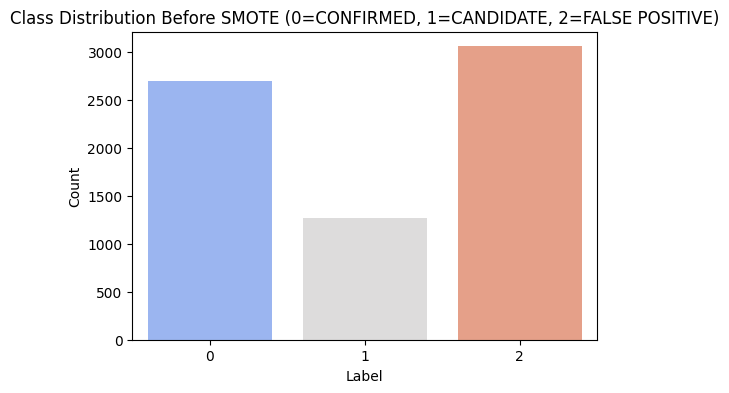


✅ After SMOTE:
label
2    3056
0    3056
1    3056
Name: count, dtype: int64


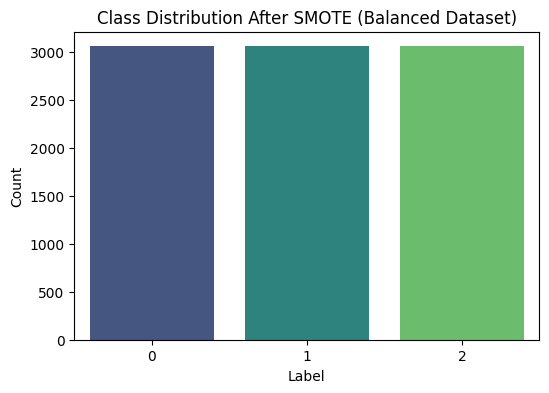


Balanced dataset shape: 9168 samples × 16 features


,koi_period,koi_duration,koi_prad,koi_depth,koi_steff,koi_srad,koi_smass,koi_model_snr,koi_max_sngle_ev,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_impact,koi_insol,duration_per_period
0,19.899140,1.78220,14.60,10829.0,5853.0,0.868,0.961,76.3,37.159767,0.0,1.0,0.0,0.0,0.969,39.30,0.089562
1,1.736952,2.40641,33.46,8079.2,5805.0,0.791,0.836,505.6,39.066550,0.0,1.0,0.0,0.0,1.276,891.96,1.385421
2,2.525592,1.65450,2.75,603.3,6031.0,1.046,1.095,40.9,4.749945,0.0,0.0,0.0,0.0,0.701,926.16,0.655094
3,11.094321,4.59450,3.90,1517.5,6046.0,0.972,1.053,66.5,9.046456,0.0,0.0,0.0,0.0,0.538,114.81,0.414131
4,4.134435,3.14020,2.77,686.0,6046.0,0.972,1.053,40.2,5.500643,0.0,0.0,0.0,0.0,0.762,427.65,0.759523


In [6]:
# ============================================
# Handle Class Imbalance Using SMOTE
# ============================================

from imblearn.over_sampling import SMOTE

print("⚖️ Balancing dataset using SMOTE...")

# 1️⃣ Check initial class distribution
print("\nBefore SMOTE:")
print(y.value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Class Distribution Before SMOTE (0=CONFIRMED, 1=CANDIDATE, 2=FALSE POSITIVE)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# 2️⃣ Apply SMOTE
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

# 3️⃣ Check new balanced class distribution
print("\n✅ After SMOTE:")
print(pd.Series(y_bal).value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x=y_bal, palette="viridis")
plt.title("Class Distribution After SMOTE (Balanced Dataset)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# 4️⃣ Display dataset shape
print(f"\nBalanced dataset shape: {X_bal.shape[0]} samples × {X_bal.shape[1]} features")

# 5️⃣ Preview balanced dataset
display(pd.DataFrame(X_bal, columns=features).head())


⚙️ Scaling features and splitting dataset...

✅ Data successfully scaled and split!
Training samples: 7334
Testing samples:  1834
Number of features: 16


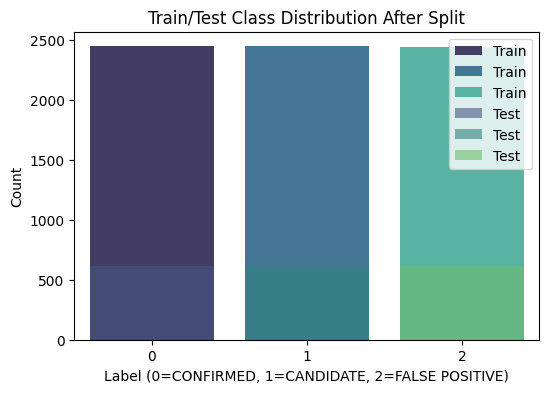

In [7]:
# ============================================
# Scale Features & Split Data
# ============================================

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("⚙️ Scaling features and splitting dataset...")

# 1️⃣ Initialize StandardScaler
scaler = StandardScaler()

# Scale the balanced dataset
X_scaled = scaler.fit_transform(X_bal)

# 2️⃣ Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_bal,
    test_size=0.2,
    stratify=y_bal,
    random_state=42
)

# 3️⃣ Print shapes
print("\n✅ Data successfully scaled and split!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples:  {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

# 4️⃣ Optional — visualize sample distribution in train/test
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=train_counts.index, y=train_counts.values, palette="mako", label="Train")
sns.barplot(x=test_counts.index, y=test_counts.values, alpha=0.6, palette="viridis", label="Test")
plt.title("Train/Test Class Distribution After Split")
plt.xlabel("Label (0=CONFIRMED, 1=CANDIDATE, 2=FALSE POSITIVE)")
plt.ylabel("Count")
plt.legend()
plt.show()


🚀 Training and comparing models...

🧠 Training Logistic Regression...
🔹 Logistic Regression Performance:
                precision    recall  f1-score   support

     CONFIRMED       0.63      0.66      0.64       611
     CANDIDATE       0.64      0.59      0.62       611
FALSE POSITIVE       0.98      1.00      0.99       612

      accuracy                           0.75      1834
     macro avg       0.75      0.75      0.75      1834
  weighted avg       0.75      0.75      0.75      1834



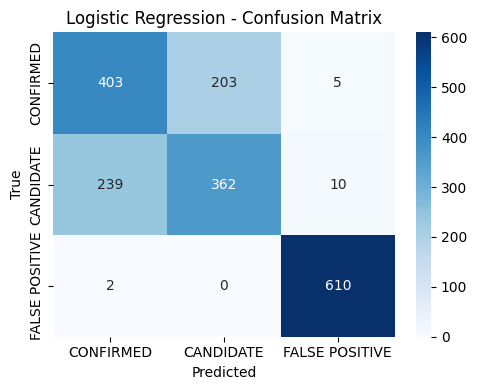


🧠 Training Random Forest...
🔹 Random Forest Performance:
                precision    recall  f1-score   support

     CONFIRMED       0.88      0.88      0.88       611
     CANDIDATE       0.89      0.87      0.88       611
FALSE POSITIVE       0.98      1.00      0.99       612

      accuracy                           0.92      1834
     macro avg       0.92      0.92      0.92      1834
  weighted avg       0.92      0.92      0.92      1834



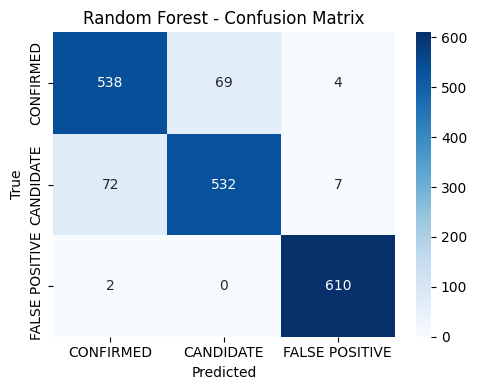


🧠 Training Neural Network...
🔹 Neural Network Performance:
                precision    recall  f1-score   support

     CONFIRMED       0.84      0.83      0.84       611
     CANDIDATE       0.84      0.85      0.84       611
FALSE POSITIVE       0.99      0.98      0.98       612

      accuracy                           0.89      1834
     macro avg       0.89      0.89      0.89      1834
  weighted avg       0.89      0.89      0.89      1834



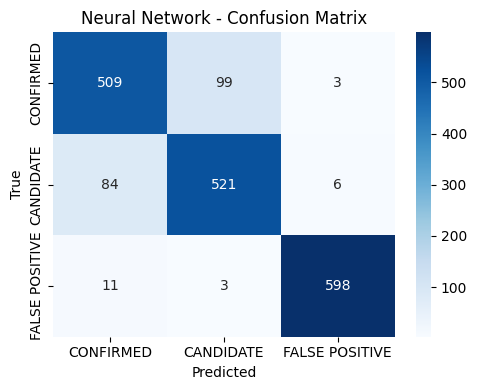


🧠 Training XGBoost...
🔹 XGBoost Performance:
                precision    recall  f1-score   support

     CONFIRMED       0.87      0.90      0.88       611
     CANDIDATE       0.90      0.86      0.88       611
FALSE POSITIVE       0.98      1.00      0.99       612

      accuracy                           0.92      1834
     macro avg       0.92      0.92      0.92      1834
  weighted avg       0.92      0.92      0.92      1834



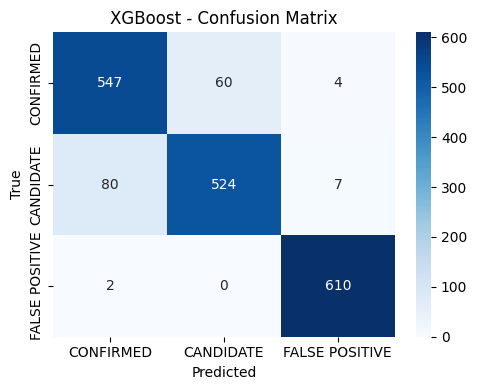

,Model,Accuracy,F1-score
3,XGBoost,0.916576,0.916274
1,Random Forest,0.916031,0.915756
2,Neural Network,0.887677,0.887851
0,Logistic Regression,0.749727,0.748175


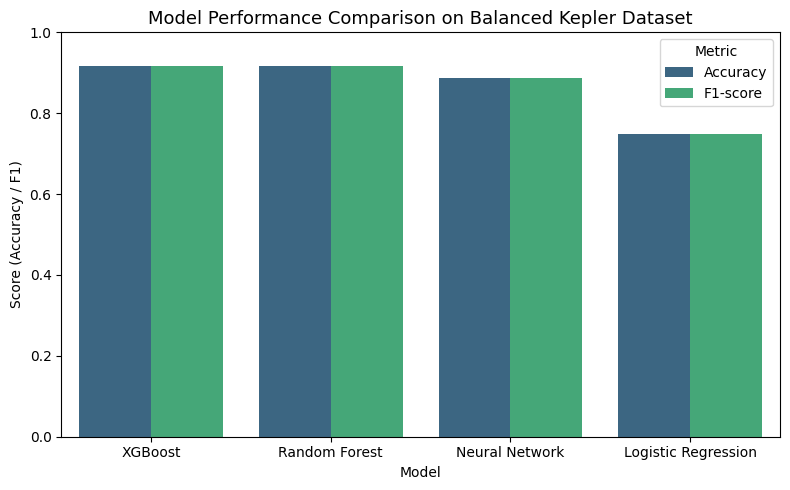

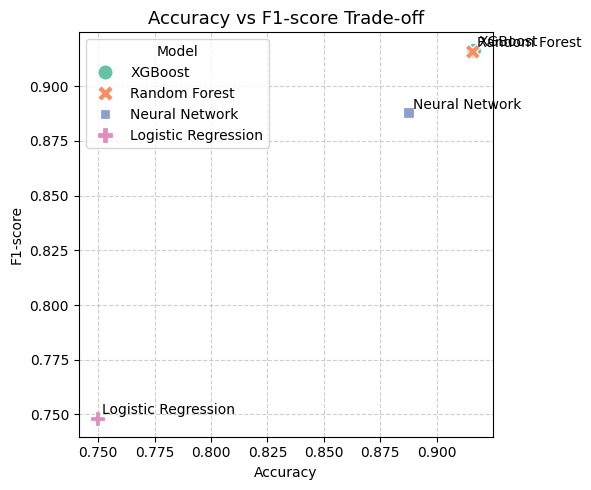

In [8]:
# ============================================
# Train and Compare Multiple Models
# ============================================

from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("🚀 Training and comparing models...")

# 1️⃣ Define models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

# 2️⃣ Train and evaluate
results = []
class_names = ["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"]

for name, model in models.items():
    print(f"\n🧠 Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    results.append({"Model": name, "Accuracy": acc, "F1-score": f1})

    # Print report
    print(f"🔹 {name} Performance:")
    print(classification_report(y_test, preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    print("="*70)

# 3️⃣ Compare results in a dataframe
results_df = pd.DataFrame(results).sort_values(by="F1-score", ascending=False)
display(results_df)

# 4️⃣ Bar chart of model performance
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
    x="Model",
    y="Score",
    hue="Metric",
    palette="viridis"
)
plt.title("Model Performance Comparison on Balanced Kepler Dataset", fontsize=13)
plt.ylabel("Score (Accuracy / F1)")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# 5️⃣ Scatter plot for Accuracy vs F1-score
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=results_df,
    x="Accuracy",
    y="F1-score",
    hue="Model",
    s=120,
    palette="Set2",
    style="Model"
)
for i, row in results_df.iterrows():
    plt.text(row["Accuracy"] + 0.002, row["F1-score"] + 0.002, row["Model"])
plt.title("Accuracy vs F1-score Trade-off", fontsize=13)
plt.xlabel("Accuracy")
plt.ylabel("F1-score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


🏆 Selecting and analyzing the best model...

🌟 Best Model Based on F1-score: XGBoost
Accuracy: 0.9166
F1-score: 0.9163


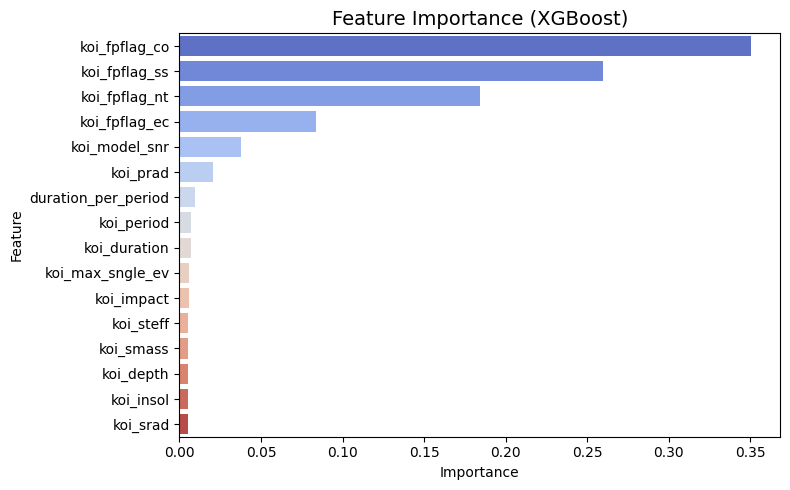


📊 Top 10 Important Features:


,Feature,Importance
11,koi_fpflag_co,0.350653
10,koi_fpflag_ss,0.259919
9,koi_fpflag_nt,0.184570
12,koi_fpflag_ec,0.083708
7,koi_model_snr,0.037637
2,koi_prad,0.020812
15,duration_per_period,0.009424
0,koi_period,0.007393
1,koi_duration,0.006847
8,koi_max_sngle_ev,0.006051


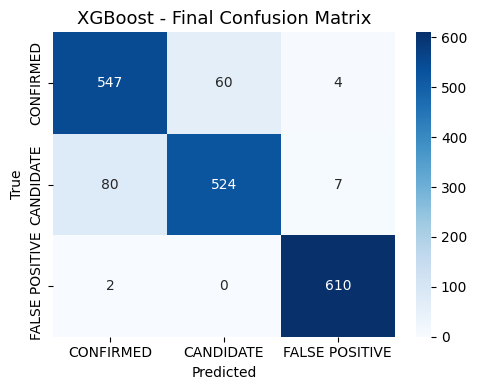


💾 Saved best model and scaler successfully!
Model filename: best_model_XGBoost.pkl

✅ Summary:
Best Model: XGBoost
Accuracy: 0.917
F1-score: 0.916


In [9]:
# ============================================
# Select Best Model, Analyze & Save
# ============================================

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

print("🏆 Selecting and analyzing the best model...")

# 1️⃣ Select the model with the highest F1-score
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n🌟 Best Model Based on F1-score: {best_model_name}")
print(f"Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"F1-score: {results_df.iloc[0]['F1-score']:.4f}")

# 2️⃣ Feature importance (for tree-based models)
if best_model_name in ["Random Forest", "XGBoost"]:
    try:
        importances = best_model.feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(8, 5))
        sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='coolwarm')
        plt.title(f"Feature Importance ({best_model_name})", fontsize=14)
        plt.tight_layout()
        plt.show()

        print("\n📊 Top 10 Important Features:")
        display(feature_importance.head(10))

    except Exception as e:
        print(f"⚠️ Could not plot feature importance for {best_model_name}: {e}")
else:
    print(f"ℹ️ {best_model_name} does not provide feature importance directly.")

# 3️⃣ Confusion matrix for best model
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = ["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"{best_model_name} - Final Confusion Matrix", fontsize=13)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 4️⃣ Save best model and scaler for future use
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_')}.pkl")
joblib.dump(scaler, "scaler.pkl")
print(f"\n💾 Saved best model and scaler successfully!")
print(f"Model filename: best_model_{best_model_name.replace(' ', '_')}.pkl")

# 5️⃣ Optional quick summary
print("\n✅ Summary:")
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {results_df.iloc[0]['Accuracy']:.3f}")
print(f"F1-score: {results_df.iloc[0]['F1-score']:.3f}")


In [10]:
# ============================================
# 🌌 NASA Kepler Exoplanet AI Classifier
# ============================================

import os
import time
from datetime import datetime
import joblib
import numpy as np
import pandas as pd
import gradio as gr
import plotly.express as px
import plotly.graph_objects as go

# ------------------------------
# Load Model and Scaler
# ------------------------------
MODEL_PATH = "best_model_XGBoost.pkl"
SCALER_PATH = "scaler.pkl"

print("🚀 Loading model and scaler...")
best_model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
print("✅ Model and scaler loaded successfully!\n")

# ------------------------------
# Feature Descriptions
# ------------------------------
feature_descriptions = {
    "koi_period": "Orbital period (days)",
    "koi_duration": "Transit duration (hours)",
    "koi_prad": "Planet radius (Earth radii)",
    "koi_depth": "Transit depth (ppm)",
    "koi_steff": "Star effective temperature (Kelvin)",
    "koi_srad": "Star radius (solar radii)",
    "koi_smass": "Star mass (solar masses)",
    "koi_model_snr": "Signal-to-noise ratio",
    "koi_max_sngle_ev": "Max single event SNR",
    "koi_fpflag_nt": "Not transit-like flag (0/1)",
    "koi_fpflag_ss": "Stellar eclipse flag (0/1)",
    "koi_fpflag_co": "Centroid offset flag (0/1)",
    "koi_fpflag_ec": "Ephemeris match flag (0/1)",
    "koi_impact": "Impact parameter (0=center, 1=edge)",
    "koi_insol": "Insolation flux (Earth flux)",
    "duration_per_period": "Transit duration / Period ratio"
}

feature_list = list(feature_descriptions.keys())
labels = ["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"]

# ------------------------------
# Utility Functions
# ------------------------------
def ensure_reports_dir():
    os.makedirs("reports", exist_ok=True)

def save_text_report(timestamp, pred_label, confidence, probs, avg_conf, runtime):
    ensure_reports_dir()
    report_file = f"reports/Exoplanet_Report_{timestamp}.txt"
    with open(report_file, "w", encoding="utf-8") as f:
        f.write("🌌 NASA Kepler Exoplanet Classifier Report\n")
        f.write("="*60 + "\n")
        f.write(f"Timestamp: {timestamp}\n\n")
        f.write(f"Predicted Class: {pred_label}\n")
        f.write(f"Confidence: {confidence:.2f}%\n\n")
        f.write("Prediction Probabilities:\n")
        for lbl, prob in zip(labels, probs):
            f.write(f"  {lbl:<15}: {prob*100:.2f}%\n")
        f.write(f"\nAverage Confidence: {avg_conf:.2f}%\nRuntime: {runtime:.3f}s\n")
    return report_file

def make_feature_importance_figure(importances):
    importances = np.array(importances) * 100
    df = pd.DataFrame({
        "Feature": feature_list,
        "Importance (%)": importances
    }).sort_values("Importance (%)", ascending=True)
    df["Color"] = ["#00CED1"] * len(df)
    for i in range(1, 4): df["Color"].iloc[-i] = "#FFD700"

    fig = px.bar(df, x="Importance (%)", y="Feature", orientation="h",
                 color="Color", color_discrete_map="identity",
                 text="Importance (%)", title="Top Influential Features",
                 template="plotly_dark", height=420)
    fig.update_traces(texttemplate="%{text:.2f}%", textposition="outside")
    fig.update_layout(paper_bgcolor="#0B0E14", plot_bgcolor="#0B0E14",
                      font=dict(color="white"), title=dict(x=0.5),
                      showlegend=False, margin=dict(l=110, r=40, t=60, b=40))
    return fig

def make_confidence_gauge(confidence, avg_conf, title):
    gauge = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=confidence,
        delta={'reference': avg_conf, 'increasing': {'color': "lime"}},
        gauge={
            'axis': {'range': [None, 100]},
            'bar': {'color': "#46C2CB"},
            'steps': [
                {'range': [0, 50], 'color': "#3A3B3C"},
                {'range': [50, 75], 'color': "#2B4F60"},
                {'range': [75, 100], 'color': "#1D7373"},
            ],
        },
        title={'text': title},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
    gauge.update_layout(template="plotly_dark", height=300,
                        paper_bgcolor="#0B0E14", font=dict(color="white"))
    return gauge

def make_probability_radar(probs):
    radar = go.Figure()
    radar.add_trace(go.Scatterpolar(
        r=list(probs * 100) + [probs[0]*100],
        theta=labels + [labels[0]],
        fill='toself', name='Class Probabilities',
        line_color='#46C2CB'
    ))
    radar.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 100])),
                        template="plotly_dark", title="Probability Radar",
                        height=400, paper_bgcolor="#0B0E14", font=dict(color="white"))
    return radar

def make_3d_feature_visualization():
    np.random.seed(42)
    df = pd.DataFrame({
        "Planet Radius": np.random.uniform(0.5, 10, 100),
        "Orbital Period": np.random.uniform(0.5, 100, 100),
        "Stellar Temp": np.random.uniform(4000, 7500, 100),
        "label": np.random.choice(["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"], 100)
    })
    fig = px.scatter_3d(df, x="Orbital Period", y="Planet Radius", z="Stellar Temp",
                        color="label", title="3D Relationship of Key Features",
                        color_discrete_map={
                            "CONFIRMED": "#00FF88",
                            "CANDIDATE": "#FFD700",
                            "FALSE POSITIVE": "#FF4C4C"
                        }, template="plotly_dark", height=450)
    fig.update_layout(paper_bgcolor="#0B0E14", font=dict(color="white"))
    return fig

# ------------------------------
# Prediction Function
# ------------------------------
def predict_exoplanet(*values):
    start_time = time.time()
    arr = np.array(values).reshape(1, -1)
    scaled_input = scaler.transform(arr)
    probs = best_model.predict_proba(scaled_input)[0]
    pred_class = int(np.argmax(probs))
    pred_label = labels[pred_class]
    runtime = time.time() - start_time

    confidence = probs[pred_class] * 100
    avg_conf = probs.mean() * 100
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    fig_imp = make_feature_importance_figure(best_model.feature_importances_)
    gauge = make_confidence_gauge(confidence, avg_conf, f"Confidence for {pred_label}")
    radar = make_probability_radar(probs)

    desc = {
        "CONFIRMED": "Strong, periodic signals consistent with known exoplanet behavior.",
        "CANDIDATE": "Likely exoplanet-like traits — needs more data for verification.",
        "FALSE POSITIVE": "Irregular or inconsistent patterns — likely not an exoplanet signal."
    }[pred_label]

    badge = {
        "CONFIRMED": "🟢 **CONFIRMED EXOPLANET**",
        "CANDIDATE": "🟡 **CANDIDATE**",
        "FALSE POSITIVE": "🔴 **FALSE POSITIVE**"
    }[pred_label]

    result_md = (
        f"### {badge}\n\n"
        f"**Confidence:** {confidence:.2f}%\n\n"
        f"**Class Probabilities:**\n"
        f"- CONFIRMED: {probs[0]*100:.2f}%\n"
        f"- CANDIDATE: {probs[1]*100:.2f}%\n"
        f"- FALSE POSITIVE: {probs[2]*100:.2f}%\n\n"
        f"Average Confidence: {avg_conf:.2f}%\n"
        f"Runtime: {runtime:.3f}s\n\n"
        f"🧠 *Interpretation:* {desc}"
    )

    report_file = save_text_report(timestamp, pred_label, confidence, probs, avg_conf, runtime)
    return result_md, fig_imp, gauge, radar, report_file

# ------------------------------
# GUI Interface
# ------------------------------
def gradio_interface():
    inputs = []
    for f, desc in feature_descriptions.items():
        label = f"{f} ({desc})"
        if "fpflag" in f:
            inputs.append(gr.Slider(0, 1, step=1, label=label))
        elif "steff" in f:
            inputs.append(gr.Number(value=5500, label=label))
        elif "period" in f or "duration" in f:
            inputs.append(gr.Number(value=10.0, label=label))
        elif "prad" in f:
            inputs.append(gr.Number(value=1.0, label=label))
        else:
            inputs.append(gr.Number(value=1.0, label=label))

    custom_css = """
    @import url('https://fonts.googleapis.com/css2?family=Orbitron:wght@500&family=Poppins:wght@300;400;500&display=swap');

    :root { --accent:#46C2CB; --bg1:#000814; --bg2:#001D3D; }

    body {
      background: url('https://cdn.wallpapersafari.com/12/9/eP7YZr.gif') no-repeat center center fixed;
      background-size: cover;
      color:#0D0C0C;
      font-family:'Poppins',sans-serif;
    }

    /* Title glow animation */
    @keyframes titleGlow {
      0% { text-shadow: 0 0 0px #46C2CB; opacity:0; transform: translateY(-10px);}
      100% { text-shadow: 0 0 10px #46C2CB, 0 0 25px #46C2CB, 0 0 45px #00FFFF; opacity:1; transform: translateY(0);}
    }

    h1 {
      font-family:'Orbitron',sans-serif!important;
      letter-spacing:2px;
      color:var(--accent)!important;
      text-transform:uppercase;
      animation: titleGlow 2s ease-out forwards;
      margin-bottom:5px;
    }

    h2,h3,p { color:#E3E8EF!important; text-shadow:none!important; }

    .gradio-container { background:rgba(0,0,0,0.45)!important; }

    .gr-box {
      border:1px solid rgba(70,194,203,.5)!important;
      background:rgba(10,15,25,.85)!important;
      border-radius:10px!important;
      box-shadow:0 0 15px rgba(70,194,203,.15);
    }

    /* Compact input fields */
    .gr-number, .gr-slider, .gr-textbox {
      max-width:300px!important;
      margin:auto!important;
      display:block!important;
    }

    .gr-column {
      align-items:center!important;
      justify-content:center!important;
    }

    .gr-input-label { color:#A1A8B8!important; font-size:13px!important; }

    /* Centered NASA header */
    #nasa-header {
      display:flex;
      flex-direction:column;
      align-items:center;
      justify-content:center;
      gap:8px;
      margin-top:25px;
    }

    #nasa-header img {
      width:130px;
      margin-bottom:6px;
      filter:drop-shadow(0 0 10px var(--accent));
    }

    hr {
      border:none;
      border-top:1px solid rgba(70,194,203,.3);
      margin:20px auto;
      width:70%;
    }

    /* Smaller Predict button */
    .gr-button {
      background:linear-gradient(90deg,#5C6BF0,var(--accent))!important;
      color:#fff!important;
      font-family:'Orbitron',sans-serif!important;
      font-weight:600!important;
      border-radius:8px!important;
      width:160px!important;
      margin:20px auto!important;
      display:block!important;
      transition:transform .2s ease, box-shadow .2s ease;
    }
    .gr-button:hover {
      transform:scale(1.05);
      box-shadow:0 0 20px var(--accent);
    }

    /* Glowing result card */
    #result-card {
      background:rgba(10,15,25,0.9);
      border:1px solid var(--accent);
      border-radius:12px;
      padding:25px;
      width:50%;
      margin:25px auto;
      text-align:center;
      box-shadow:0 0 25px rgba(70,194,203,.3);
      font-family:'Poppins',sans-serif;
      color:#E3E8EF;
      animation: fadeIn 1s ease-in;
    }

    @keyframes fadeIn {
      from { opacity:0; transform: translateY(20px);}
      to { opacity:1; transform: translateY(0);}
    }
    """

    with gr.Blocks(css=custom_css, theme="soft") as gui:
        gr.HTML("""
        <div id="nasa-header">
          <img src="https://upload.wikimedia.org/wikipedia/commons/e/e5/NASA_logo.svg" alt="NASA">
          <h1>Kepler Exoplanet AI Classifier</h1>
          <p style="color:#A9B3C1">Exploring worlds beyond our own 🌠</p>
          <hr>
        </div>
        """)

        with gr.Tabs():
            with gr.Tab("🔮 Prediction"):
                gr.Markdown("### 🧩 Input Parameters")

                with gr.Row():
                    with gr.Column(scale=1):
                        with gr.Accordion("🌞 Star & Planet Parameters", open=True):
                            for comp in inputs[:8]:
                                comp.render()
                    with gr.Column(scale=1):
                        with gr.Accordion("⚙️ Flags & Ratios", open=True):
                            for comp in inputs[8:]:
                                comp.render()

                predict_btn = gr.Button("🚀 Predict", variant="primary")
                out_summary = gr.Markdown(elem_id="result-card")
                with gr.Row():
                    out_gauge = gr.Plot()
                    out_radar = gr.Plot()
                out_imp = gr.Plot()
                out_report = gr.File(label="📁 Generated Report")

                predict_btn.click(
                    fn=predict_exoplanet,
                    inputs=inputs,
                    outputs=[out_summary, out_imp, out_gauge, out_radar, out_report],
                    show_progress="full"
                )

            with gr.Tab("🧠 Model Insights"):
                gr.Markdown("""
                ## 🛰️ Model Overview
                We trained and compared multiple machine learning models on NASA’s **Kepler Objects of Interest (KOI)** dataset.
                After extensive testing, **XGBoost** demonstrated the best performance in both **accuracy** and **F1-score**.

                ### ⚖️ Model Comparison Summary
                | Model | Accuracy | F1-Score |
                |:--|:--:|:--:|
                | Logistic Regression | 74.97% | 74.82% |
                | Neural Network | 88.76% | 88.78% |
                | Random Forest | 91.60% | 91.57% |
                | 🏆 **XGBoost (Selected)** | **91.66%** | **91.63%** |

                ### 🔍 Why XGBoost?
                - Excellent generalization with structured tabular data
                - Robust to missing values and feature scaling
                - Handles imbalanced datasets efficiently
                - Delivers interpretable feature importance scores
                - Achieved the most consistent validation performance

                ### 🧠 Model Summary
                The final classifier integrates:
                - **Feature engineering:** Normalization + transit duration ratio
                - **Cross-validation:** 5-fold stratified
                - **Performance metrics:** Accuracy, F1, Precision, Recall
                - **Visualization tools:** Plotly 3D scatter + feature importance charts
                """)

                gr.Plot(value=make_3d_feature_visualization(), label="🌌 3D Feature Relationships")

            with gr.Tab("📜 About"):
                gr.Markdown("""
                ## 🌍 About the Project – NASA Space Apps Challenge 2025
                **Challenge:** *A World Away – Hunting for Exoplanets with AI*
                **Event Date:** October 4–5, 2025
                **Organized by:** NASA Space Apps, in partnership with Booz Allen Hamilton, Mindgrub, and SecondMuse.

                ### 🚀 What is the Challenge?
                The objective is to develop an **AI/ML-powered tool** that can automatically detect exoplanets from datasets collected by NASA missions such as **Kepler**, **K2**, and **TESS**.
                Traditionally, exoplanet discovery relied on manual analysis of light curves — this challenge encourages participants to **automate** that process using advanced machine learning.

                ### 👨‍💻 Who We Are
                We are **Team Hunters**, a group of Computing Science students from Thompson Rivers University(Kamloops), driven by curiosity about the cosmos.
                Our mission is to combine **AI, astrophysics, and interactive visualization** to make space data accessible and insightful for researchers and learners alike.

                ### 🧠 Our Approach
                Our pipeline consists of the following steps:
                1. **Data Acquisition:** NASA’s open-source Kepler KOI dataset.
                2. **Data Cleaning & Feature Engineering:**
                   - Missing value imputation
                   - Outlier removal using z-score filtering
                   - Feature normalization and derived metrics like *Transit Duration/Period Ratio*
                3. **Model Training:**
                   - Compared multiple ML models (Logistic Regression, Random Forest, MLP, XGBoost)
                   - Selected **XGBoost** for highest accuracy and interpretability.
                4. **Explainability:**
                   - Visualized feature importance and probability distributions using **Plotly**.
                5. **Deployment:**
                   - Built an interactive web interface with **Gradio**, styled to emulate NASA’s mission control dashboard.

                ### 🧩 Tech Stack
                - **Languages:** Python
                - **Libraries:** Scikit-learn · XGBoost · Plotly · Gradio · Pandas · NumPy
                - **Environment:** Google Colab + Gradio Cloud
                - **Design:** Space-themed responsive interface with live model visualizations

                ### 🌠 Future Work
                - Integrate TESS and K2 datasets for cross-mission prediction
                - Add a *Mission Log* to record user predictions
                - Explore LSTM-based light curve classification
                - Publish an open dataset for community collaboration

                ---
                **Developed by:** *Rafid Hasan, Tanjim Sohan & Hasan Mifta*
                *For the 2025 NASA Space Apps Challenge – “A World Away: Hunting for Exoplanets with AI”*
                """)

    gui.launch(share=False, debug=False)





# ------------------------------
# Mode Selector
# ------------------------------
if __name__ == "__main__":
    print("\n🧠 Choose Mode:")
    print("1️⃣ Console Mode")
    print("2️⃣ GUI Mode (Gradio + Plotly)")
    choice = input("Enter 1 or 2: ").strip()
    if choice == "1":
        print("Console mode selected — coming soon.")
    else:
        gradio_interface()


🚀 Loading model and scaler...
✅ Model and scaler loaded successfully!


🧠 Choose Mode:
1️⃣ Console Mode
2️⃣ GUI Mode (Gradio + Plotly)
Enter 1 or 2: 2
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>